In [1]:
import json
import io
import contextlib

from GEE_Processor import gee_processor
from Fire_Detector import fire_detector

In [2]:
# 1 Load the configuration file.
with open('input.json', 'r') as f:
    config = json.load(f)

In [3]:
# 2 Pre-process and download the NDVI time series data from GEE

# Get the selected remote sensing data
processor = gee_processor(
    study_area_shp_path=config['gee_processor']['study_area_shp_path'],
    start_date=config['gee_processor']['start_date'],
    end_date=config['gee_processor']['end_date'],
    land_cover_data=config['gee_processor']['land_cover_data'],
    remote_sensing_data=config['gee_processor']['remote_sensing_data']
)

# Get the NDVI stack
NDVI_stack = processor.NDVI_Exract_Stack()

# Export the NDVI stack
band_names = processor.export_image(
    NDVI_stack,
    filename=config['export_image']['image_path'],
    filename_band_name=config['export_image']['image_band_name'],
    scale=config['export_image']['scale'],
    crs=config['export_image']['crs'],
    unmask_value=config['export_image']['unmask_value']
)

# Visualize the study area and the NDVI stack
processor.geemap_export(NDVI_stack,config['export_image']['geemap_html'])


Google Earth Engine has initialized successfully!
Generating URL ...
Please wait ...
Data downloaded to c:\Users\risen\OneDrive - University of Twente\EMSITS\Fire_Detection_BEAST\MODIS_File\NDVI_stack.tif
Exporting MODIS_File/NDVI_stack.tif to GeoTIFF...
Band names saved to MODIS_File/band_name.npy
Geemap saved to MODIS_File/Map.html.


Detecting fire: 100%|██████████| 10120/10120 [46:52<00:00,  3.60it/s] 


Temporal variable saved to temporal_time_series_after_detection.pkl
Fire detection visualisation saved to Fire_Detection_Result/Fire_Detection_Result.png
Fire detection visualisation (by time) saved to Fire_Detection_Result/Fire_Time_Count_by_Half_Year.png
Result Raster image saved to Fire_Detection_Result/Fire_Detection_Result.tif
Confusion Matrix:
[[8329  239]
 [ 411 1141]]
Accuracy: 0.94
Precision: 0.83
Recall: 0.74
F1 Score: 0.78
Kappa Score: 0.74
Fire detection visualisation saved to Fire_Detection_Result//Validation_Result/validation_result.png


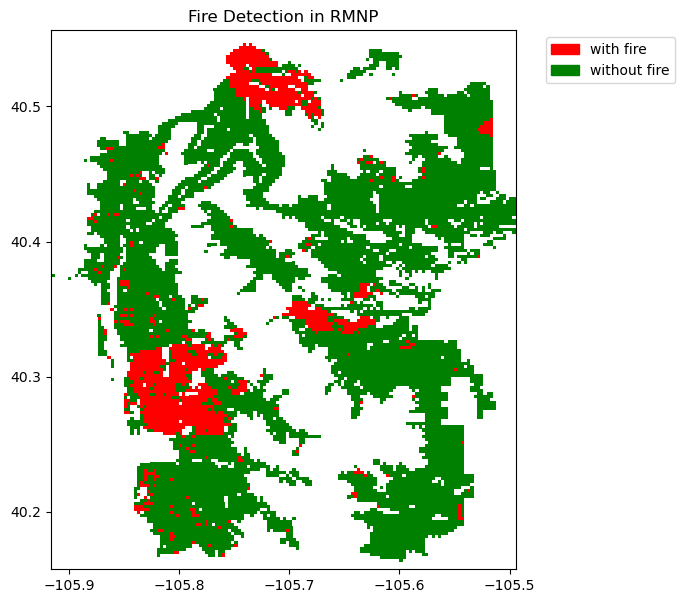

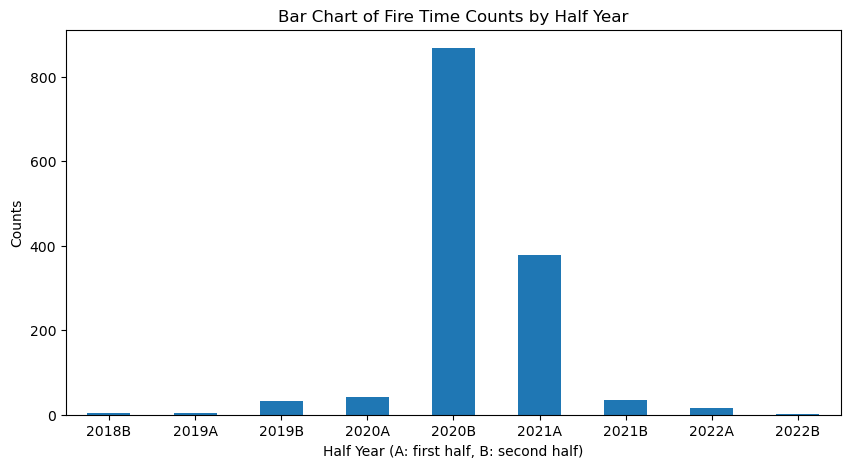

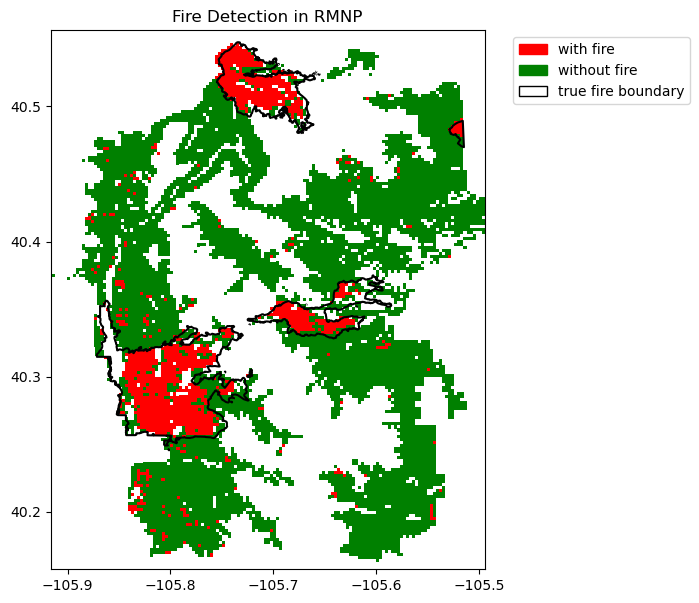

In [4]:
# 3 Fire Detection with Rbeast

# create a string stream object
output = io.StringIO()

# use contextlib to redirect the stdout to the string stream object
with contextlib.redirect_stdout(output):
    # Run the fire detection
    detector = fire_detector(
        file_path=config['export_image']['image_path'],
        file_band_names=config['export_image']['image_band_name'],
        crs=config['export_image']['crs'],
        unmask_value=config['export_image']['unmask_value'],
        nan_ratio_threshold=config['fire_detector']['nan_ratio_threshold'],
        BEAST_belief_threshold=config['fire_detector']['BEAST_belief_threshold'],
        result_directory=config['fire_detector']['result_directory']
    )
    # Detect the fire on each pixel's time series
    time_series_after_detection = detector.detect_fire()

# Save the fire detection result as a temporal variable to avoid re-running the detection
time_series_after_detection_temporary_path = 'temporal_time_series_after_detection.pkl'
detector.save_temporal_variable(time_series_after_detection,time_series_after_detection_temporary_path)
# Load the fire detection result as a temporal variable
# time_series_after_detection = detector.load_temporal_variable(time_series_after_detection_temporary_path)

# Visualize the fire detection result
image = detector.fire_visualization(time_series_after_detection)
detector.fire_visualization_by_time(time_series_after_detection)
# Export the fire detection result as a raster
result_raster_path = detector.result_exported_as_raster(image)
# Validate the fire detection result
validation_shp_path = config['fire_detector']['validation_shp_path']
detector.result_validation(result_raster_path,validation_shp_path)